# Detecting Weird Web Traffic
The goal for this project is to find anomalies in web traffic from different regions. Ideally the IT department would like to know when we're seeing spikes in data so they can preemptively deploy our web security team. They think that when the number of hits goes above 190 it might be a good indicator that something weird is happening

<p><strong>Goal</strong> - Detect anomalous web traffic</p>
<p><strong>Data</strong> - Web traffic by hosting region over time</p>
<p><strong>Task</strong> - Unsupervised anomaly detection</p>

# 1. Import Data

In [18]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
0,1/1/2021,123.594462,179.799106,142.051377,165.898948,211.796438,140.574596
1,2/1/2021,96.913589,142.312297,98.873977,160.450595,126.403444,146.323197
2,3/1/2021,127.769080,205.521667,102.443675,127.585609,243.919837,211.321143
3,4/1/2021,232.383608,157.833057,151.695219,184.958764,112.802699,169.354083
4,5/1/2021,121.971639,166.400354,139.208040,105.576656,91.234096,221.821293


# 2. Analyse Train Set to Prevent Data Snooping Bias

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train, test = train_test_split(df, test_size=0.3, random_state=1234)

In [7]:
train.shape

(368, 7)

In [8]:
test.shape

(158, 7)

In [9]:
test.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
261,19/9/2021,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842
425,2/3/2022,155.830214,137.432916,165.569703,110.725701,123.453509,159.390772
21,22/1/2021,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156
329,26/11/2021,189.518384,134.788869,161.219281,85.183524,124.251407,157.197199
310,7/11/2021,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637


In [10]:
train.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
436,13/3/2022,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418
470,16/4/2022,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732
521,6/6/2022,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250
118,29/4/2021,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559
162,12/6/2021,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077


# 3. Exploratory Data Analysis

## Bird's Eye View

In [11]:
train.dtypes

Date         object
Region 1    float64
Region 2    float64
Region 3    float64
Region 4    float64
Region 5    float64
Region 6    float64
dtype: object

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368 entries, 436 to 294
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      368 non-null    object 
 1   Region 1  368 non-null    float64
 2   Region 2  368 non-null    float64
 3   Region 3  368 non-null    float64
 4   Region 4  368 non-null    float64
 5   Region 5  368 non-null    float64
 6   Region 6  368 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.0+ KB


In [13]:
train.describe()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,151.128974,167.734819,155.862138,157.182245,161.480763,153.131734
std,51.369861,95.484190,80.129220,71.864944,91.850797,52.667582
min,11.184334,7.461471,-8.153494,-9.810526,-19.235141,-9.713714
25%,118.151654,126.804343,115.367657,121.458658,117.213061,119.523299
50%,150.579649,152.687679,147.487873,152.710155,151.404897,150.309562
75%,183.908133,192.515750,182.791165,188.930369,184.605039,185.003355
max,505.000000,784.000000,782.000000,723.000000,759.000000,404.000000


In [14]:
# 1.5 IQR - Region 4
188+1.5*(188-121)

288.5

In [15]:
# 1.5 IQR - Region 2
192.5+1.5*(192-126)

291.5

## Plot Distributions

In [16]:
from pandas.plotting import scatter_matrix

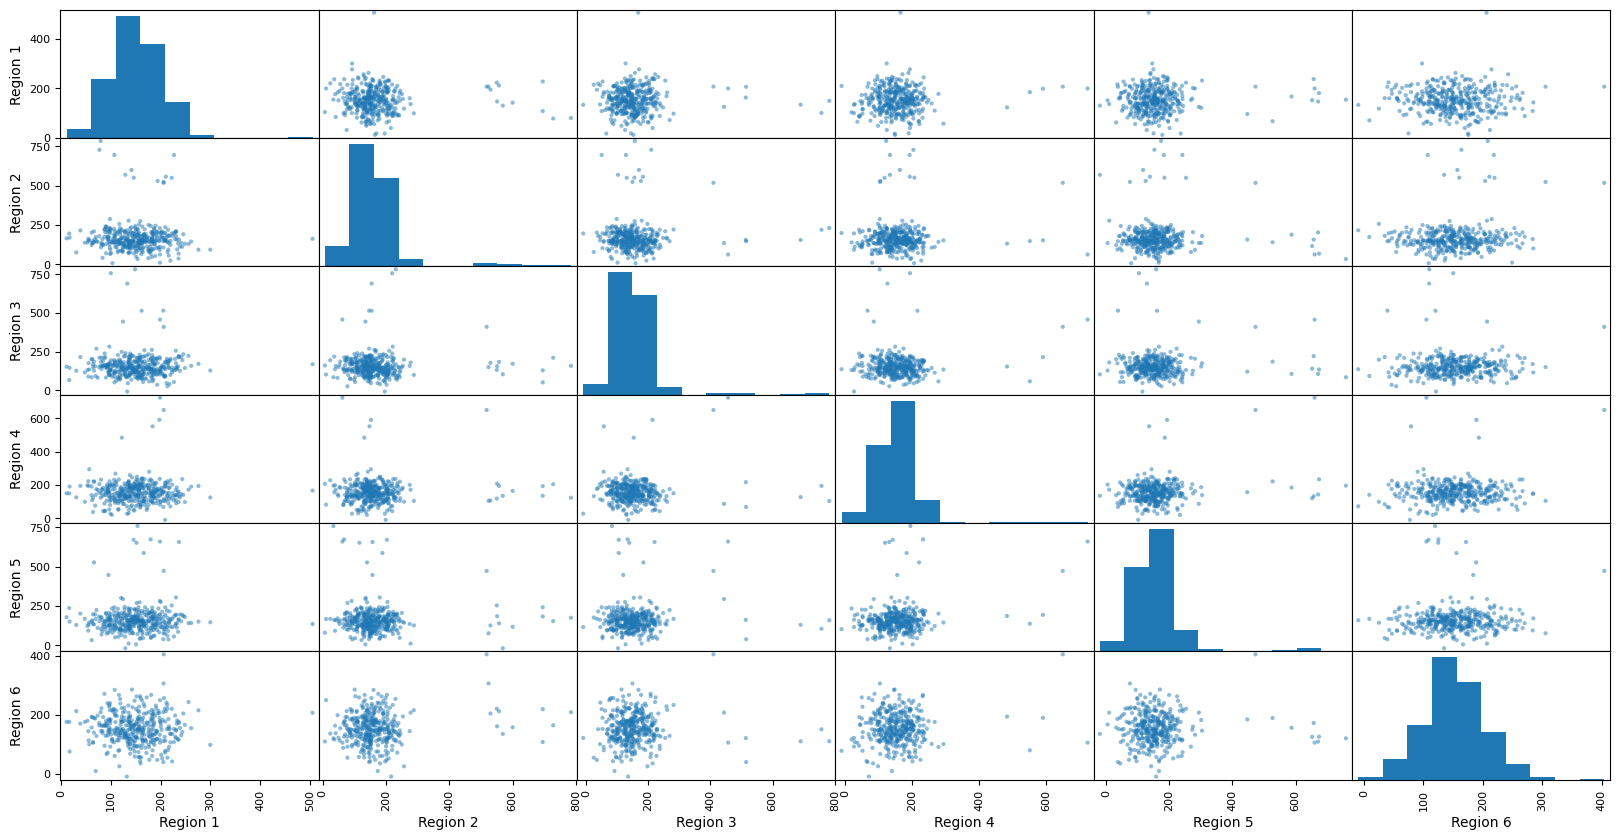

In [19]:
scatter_matrix(train, figsize=(20,10))
plt.show()

## Fix Date Column to Be the appropriate Datatype

In [20]:
train['Date'] = pd.to_datetime(train['Date'], format="%d/%m/%Y")

In [21]:
train.dtypes

Date        datetime64[ns]
Region 1           float64
Region 2           float64
Region 3           float64
Region 4           float64
Region 5           float64
Region 6           float64
dtype: object

In [22]:
train.iloc[0].Date.is_month_end

False

## Can we visually see anomalies?

In [24]:
import seaborn as sns

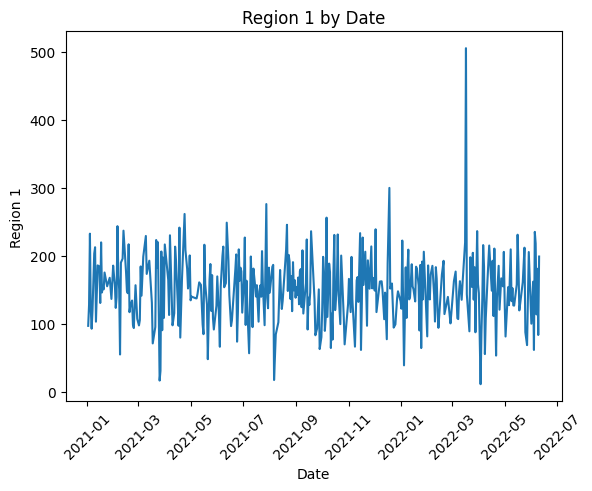

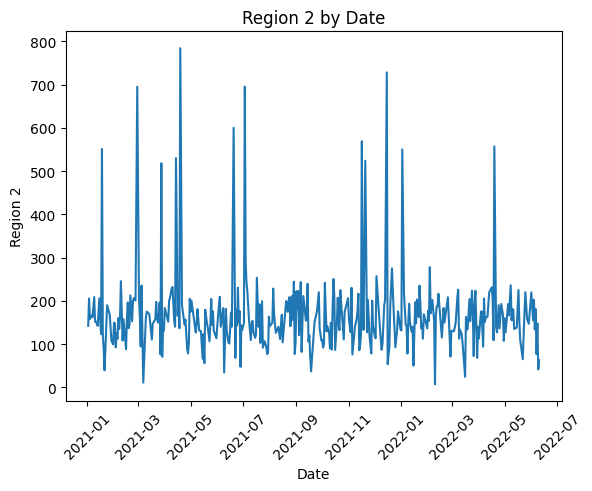

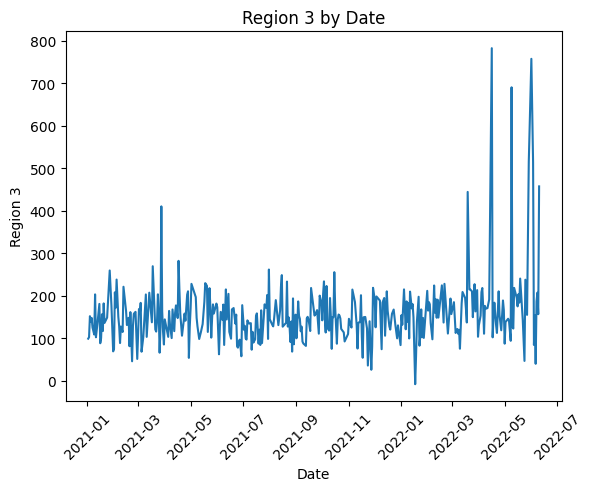

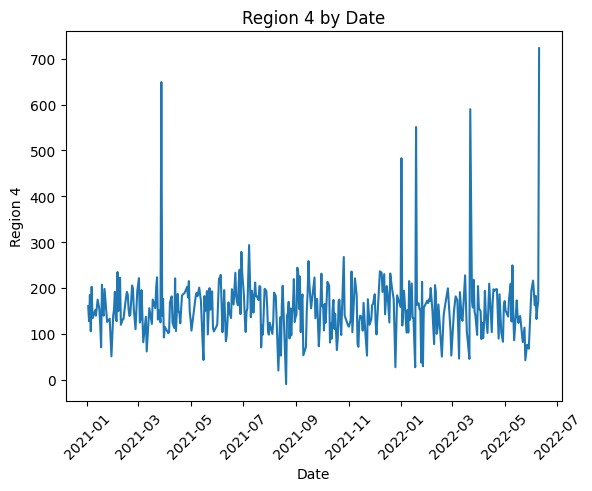

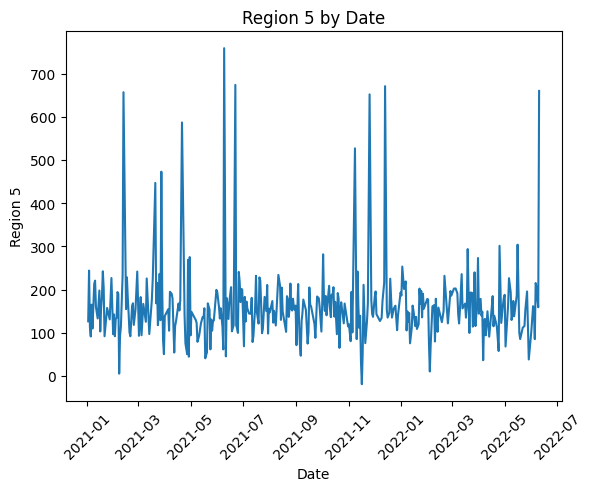

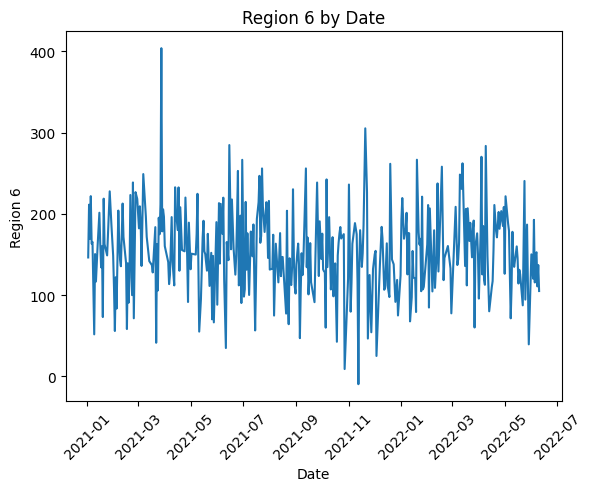

In [27]:
for col in train.columns[1:]: 
    plt.title(f'{col} by Date')
    sns.lineplot(x='Date', y=col, data=train)
    plt.xticks(rotation=45)
    plt.show()

## Do the Spikes have anything to do with time?

In [28]:
train['spike'] = (train[train.columns[1:]] >= 250).any(axis=1).astype(int)

In [29]:
train[train['spike'] ==1]

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,spike
436,2022-03-13,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418,1
470,2022-04-16,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732,1
323,2021-11-20,205.861833,524.000000,149.952931,104.507053,75.771865,305.307234,1
278,2021-10-06,255.972485,129.492414,222.723926,171.396058,140.339710,242.433164,1
298,2021-10-26,109.370524,110.805624,113.617779,267.659334,121.693990,175.050036,1
...,...,...,...,...,...,...,...,...
412,2022-02-17,172.005079,115.304617,224.235487,50.402924,124.385924,258.080155,1
76,2021-03-18,71.122607,147.096293,269.230290,174.748618,223.647638,127.880359,1
383,2022-01-19,180.961109,203.285627,138.829689,162.835031,108.678613,266.659734,1
336,2021-12-03,117.150981,257.156539,198.157185,98.776494,142.922834,25.043718,1


In [30]:
train['day'] = train['Date'].dt.dayofweek
train['month'] = train['Date'].dt.month
train['year'] = train['Date'].dt.year
train['monthstart'] = train['Date'].dt.is_month_start
train['monthend'] = train['Date'].dt.is_month_end
train['quarterstart'] = train['Date'].dt.is_quarter_start
train['quarterend'] = train['Date'].dt.is_quarter_end

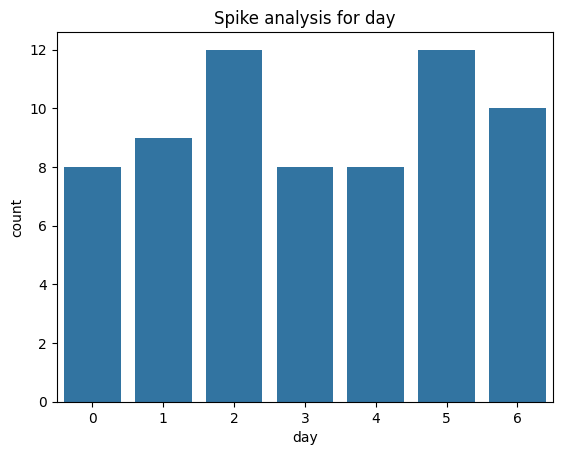

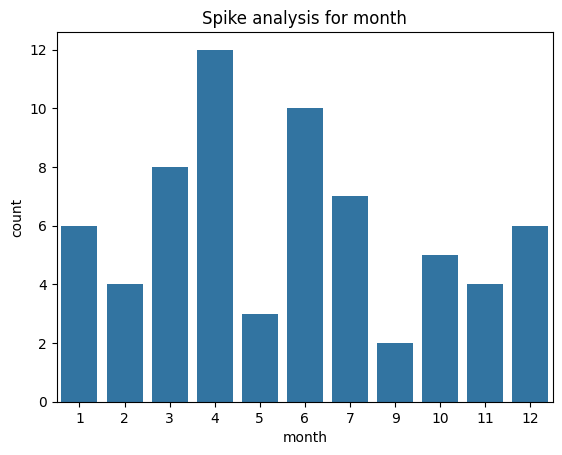

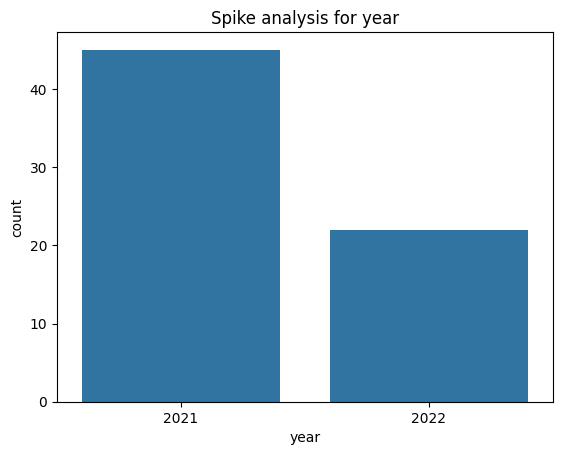

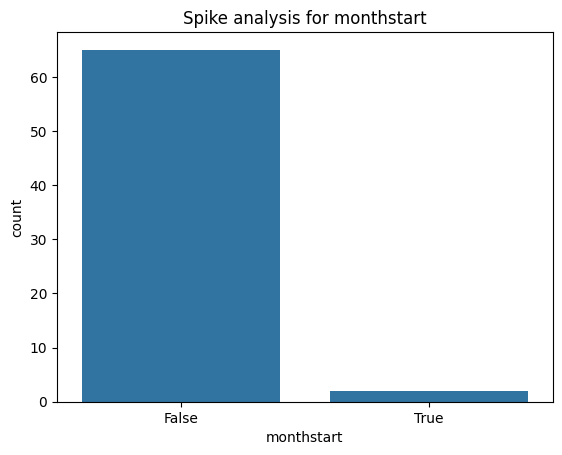

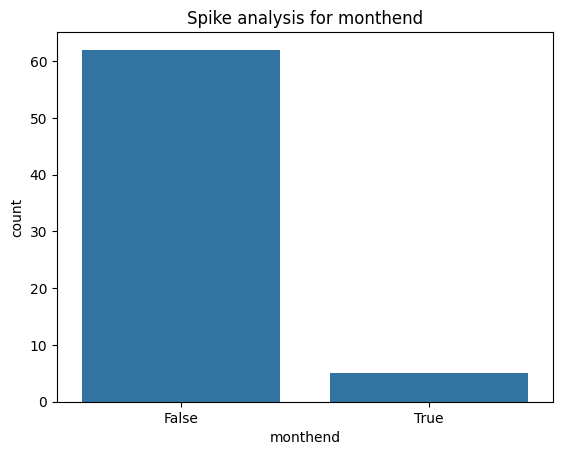

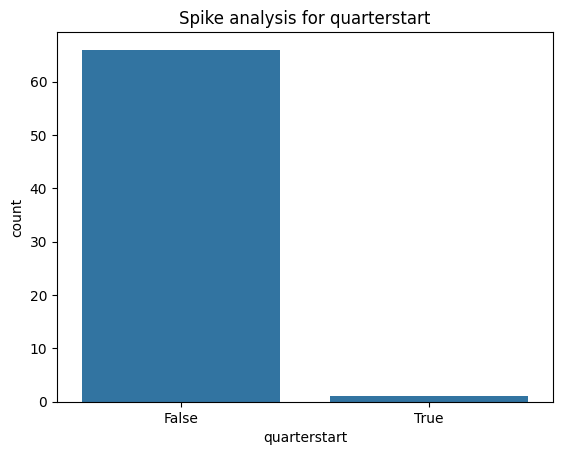

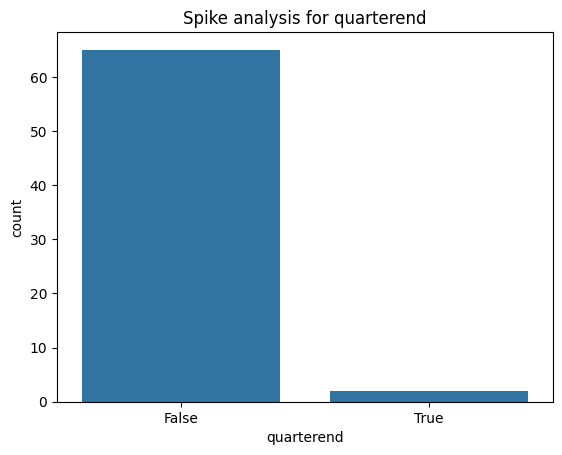

In [31]:
time_cols = ['day','month', 'year', 'monthstart','monthend','quarterstart','quarterend']
for col in time_cols: 
    plt.title(f'Spike analysis for {col}')
    sns.countplot(x=col, data=train[train['spike']==1])
    plt.show()

In [32]:
train.drop(time_cols, axis=1, inplace=True)

In [33]:
train.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,spike
436,2022-03-13,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418,1
470,2022-04-16,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732,1
521,2022-06-06,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250,0
118,2021-04-29,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559,0
162,2021-06-12,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077,0


## Analyse Correlation

In [34]:
train.select_dtypes(include=[float, int]).corr()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,spike
Region 1,1.000000,-0.021998,0.016817,0.058301,0.043939,-0.000046,0.126999
Region 2,-0.021998,1.000000,0.005645,0.035998,-0.030305,0.131186,0.363026
Region 3,0.016817,0.005645,1.000000,0.081737,0.046921,0.015633,0.300963
Region 4,0.058301,0.035998,0.081737,1.000000,0.231511,0.074267,0.237912
Region 5,0.043939,-0.030305,0.046921,0.231511,1.000000,0.012228,0.341970
Region 6,-0.000046,0.131186,0.015633,0.074267,0.012228,1.000000,0.224595
spike,0.126999,0.363026,0.300963,0.237912,0.341970,0.224595,1.000000


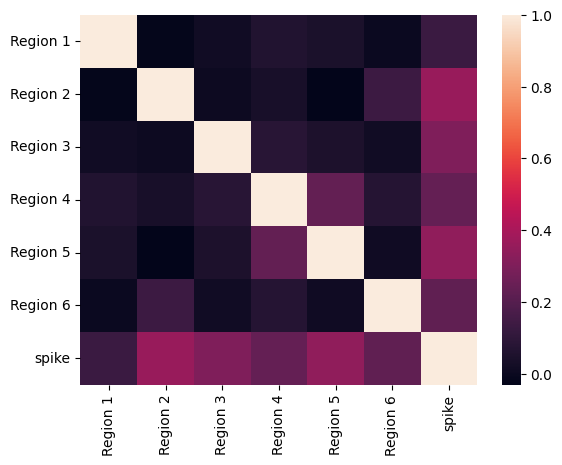

In [35]:
sns.heatmap(train.select_dtypes(include=[float, int]).corr())
plt.show()

# 4. Data Preprocessing

## Drop Date and Add Spike Col to Test Set

In [36]:
X_train = train.drop(['Date','spike'], axis=1)
X_test = test.drop('Date', axis=1)

In [37]:
X_train.head()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
436,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418
470,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732
521,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250
118,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559
162,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077


In [38]:
X_test.head()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842
425,155.830214,137.432916,165.569703,110.725701,123.453509,159.390772
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156
329,189.518384,134.788869,161.219281,85.183524,124.251407,157.197199
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637


# 5. Modelling

## Build ML Pipelines

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [40]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [41]:
pipelines = {
    'iso':make_pipeline(StandardScaler(), IsolationForest(n_estimators=300, random_state=1234)),
    'lof':make_pipeline(StandardScaler(), LocalOutlierFactor(n_neighbors=20, novelty=True)),
    'svm':make_pipeline(StandardScaler(), OneClassSVM())
}

## Train Models

In [42]:
fit_models = {}
for algo, model in pipelines.items():
    print(f'Commencing training for {algo}')
    model.fit(X_train)
    fit_models[algo] = model 
    print(f'Completed training for {algo}')

Commencing training for iso
Completed training for iso
Commencing training for lof
Completed training for lof
Commencing training for svm
Completed training for svm


In [43]:
fit_models

{'iso': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('isolationforest',
                  IsolationForest(n_estimators=300, random_state=1234))]),
 'lof': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('localoutlierfactor', LocalOutlierFactor(novelty=True))]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('oneclasssvm', OneClassSVM())])}

# 6. Evaluate Models

## Create a Scoring Matrix For All Models

In [44]:
result_df = X_test.copy()
for algo, model in fit_models.items():
    res = model.predict(X_test)
    result_df[algo] = res

In [45]:
result_df.head()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842,1,1,-1
425,155.830214,137.432916,165.569703,110.725701,123.453509,159.390772,1,1,1
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156,1,1,-1
329,189.518384,134.788869,161.219281,85.183524,124.251407,157.197199,1,1,1
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637,1,1,-1


In [46]:
result_df[result_df['svm']==-1]

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842,1,1,-1
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156,1,1,-1
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637,1,1,-1
66,89.879803,201.130424,134.432471,281.407783,159.461995,230.804372,1,1,-1
124,129.499511,462.000000,26.431366,162.445374,202.411825,157.847851,1,-1,-1
...,...,...,...,...,...,...,...,...,...
43,242.058629,156.975012,142.625262,130.416922,149.543268,174.722216,1,1,-1
115,145.231810,141.420973,218.935651,50.286454,138.589165,164.643271,1,1,-1
93,125.446549,45.943054,136.094739,148.353361,110.219904,215.959099,1,1,-1
362,142.876137,193.744128,111.953142,101.922023,263.122229,89.099177,1,1,-1


In [47]:
result_df['spike'] = (result_df[result_df.columns[0:6]] >=250).any(axis=1).astype(int)
result_df['spike'] = result_df['spike'].replace(1,-1).replace(0,1)

In [48]:
result_df[result_df['svm']==-1]

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm,spike
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842,1,1,-1,1
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156,1,1,-1,1
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637,1,1,-1,1
66,89.879803,201.130424,134.432471,281.407783,159.461995,230.804372,1,1,-1,-1
124,129.499511,462.000000,26.431366,162.445374,202.411825,157.847851,1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
43,242.058629,156.975012,142.625262,130.416922,149.543268,174.722216,1,1,-1,1
115,145.231810,141.420973,218.935651,50.286454,138.589165,164.643271,1,1,-1,1
93,125.446549,45.943054,136.094739,148.353361,110.219904,215.959099,1,1,-1,1
362,142.876137,193.744128,111.953142,101.922023,263.122229,89.099177,1,1,-1,-1


## Calculate Proxy Performance

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [54]:
for key in fit_models.keys(): 
    ytrue = result_df['spike'].replace(1,0).replace(-1,1)
    yhat = result_df[key].replace(1,0).replace(-1,1)
    precision = precision_score(ytrue, yhat)
    recall = recall_score(ytrue, yhat)
    f1 = f1_score(ytrue, yhat)
    print(f'{key}: Precision:{precision}, Recall:{recall}, F1:{f1}')

iso: Precision:1.0, Recall:0.30434782608695654, F1:0.4666666666666667
lof: Precision:0.9090909090909091, Recall:0.43478260869565216, F1:0.5882352941176471
svm: Precision:0.26582278481012656, Recall:0.9130434782608695, F1:0.4117647058823529


In [52]:
ytrue = result_df['spike']
yhat = result_df['lof']

In [53]:
confusion_matrix(ytrue, yhat, labels=[-1,1])

array([[ 10,  13],
       [  1, 134]])

## Make Predictions

In [55]:
fit_models['lof'].predict(X_test)

array([ 1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

## Save Models

In [56]:
import joblib

In [57]:
joblib.dump(fit_models['lof'], 'localoutlierfactor.joblib')

['localoutlierfactor.joblib']

# 7. Building a Gradio Checker APP

## Setup Gradio

In [58]:
def predict(region1, region2, region3, region4, region5, region6): 
    model = joblib.load('localoutlierfactor.joblib')
    yhat = model.predict(np.array([[region1, region2, region3, region4, region5, region6]]))
    return 'Weird Traffic' if yhat == -1 else 'Normal Traffic'

In [59]:
X_test.iloc[0]

Region 1    174.982473
Region 2    188.073353
Region 3    212.564889
Region 4    227.348706
Region 5     90.856875
Region 6    228.446842
Name: 261, dtype: float64

In [60]:
result_df[result_df['lof']==-1][result_df.columns[0:6]].iloc[0].tolist()

[129.4995114, 462.0, 26.43136618, 162.4453741, 202.411825, 157.8478515]

In [61]:
predict(*result_df[result_df['lof']==-1][result_df.columns[0:6]].iloc[0].tolist())

c:\Users\91798\Documents\Full Stack Machine Learning\Web Traffic Detection\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'Weird Traffic'

## Build and Share Gradio App

In [62]:
import gradio as gr

c:\Users\91798\Documents\Full Stack Machine Learning\Web Traffic Detection\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
app = gr.Interface(
    title='Traffic Anomaly Detection 🚦',
    fn=predict, 
    inputs=[gr.Slider(0,800),gr.Slider(0,800),gr.Slider(0,800),gr.Slider(0,800),gr.Slider(0,800),gr.Slider(0,800)], 
    outputs='text'
)

In [66]:
app.launch(auth=("admin_user", "mySecretPa55w0rd"), share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
